In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
import numpy as np
import os


instr = 'maxi'
# instr = 'xrt'

# Define the pattern to match the CSV files
file_pattern = '/disk/data/youssef/scripts/xrb-population/results_old/'+instr+'_results/merged_files/*.csv'
csv_files = [file for file in glob(file_pattern) if "full" not in file]
# csv_files = [file for file in csv_files if "T0.3" not in file]
# csv_files = [file for file in csv_files if "r0.7" not in file]
 
# Function to extract parameter values from filenames
def extract_parameters(filename):
    pattern = r'table_g(?P<g>\d+\.\d+)_T(?P<T>\d+\.\d+)_a(?P<a>\d+\.\d+)_m(?P<m>\d+\.\d+)_i(?P<i>\d+\.\d+)_r(?P<r>\d+\.\d+)_e(?P<e>\d+\.\d+)\.csv'
    match = re.search(pattern, filename)
    if match:
        return {key: float(value) for key, value in match.groupdict().items()}
    else:
        return None

# List to store summary statistics
summary_data = []

# Initialize an empty list to store distances
distances = []

# Initialize an empty list to store distances with non-available 'frac_uncert'
na_distances = []

# Initialize an empty list to all data
all_data = []

# Initialize a dictionary to store filenames with non-available 'd_fit'
na_d_fit_files = []

na_d_fit_params = []

na_nH = []

all_data_params= []

# Process each file
for file in csv_files:
    parameters = extract_parameters(file)
    if parameters:
        try:
            data = pd.read_csv(file)    
            # Filter rows where the absolute fractional uncertainty is less than 0.5
            
            filtered_data = data[abs(data['frac_uncert']) < 10]
            
            
            # filtered_data2 = data[abs(data['frac_uncert']) < 0.5]
            filtered_data2 = data[data['d_fit'].notna()]
            
            # Append the distances ('d') to the list
            distances.extend(filtered_data2['d'].values)
            na_data = data[data['d_fit'].isna()]
            na_distances.extend(na_data['d'].values)
            na_nH.extend(na_data['nH'].values)

            all_data.append(filtered_data[['nH', 'd', 'frac_uncert','d_fit']])
            all_data_params.append(parameters)
            # Check if 'd_fit' contains NaN and store filename if true
            if data['d_fit'].isna().all() or all(abs(data['frac_uncert']) > 0.5):
                na_d_fit_files.append(os.path.basename(file))
                # Extract parameters from the filename using regex
                params = parameters
                na_d_fit_params.append(params)
        except Exception as e:
            print(f"Error processing file {file}: {e}")

In [1]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit

def exp_decay(x,a,b):
    return b*np.exp(-a*x)

def volume_density_exp_decay(x,L):
    return (1/(2*(L**3)))*(x**2)*np.exp(-(x/L))

n, bins,_ = plt.hist(distances, bins=50, edgecolor='black',density = True)

print(n.sum()*(bins[1]-bins[0]))

# plt.show()

xdata = bins[:-1] + ((bins[1:]-bins[:-1])/2) 

xdata = xdata[n>0]

ydata = n[n>0]

popt, pcov = curve_fit(volume_density_exp_decay, xdata, ydata)

# distances_numpy = np.array(distances)
# kde = KernelDensity(kernel='gaussian', bandwidth=5).fit(distances_numpy.reshape(-1, 1))
distances_plot = np.linspace(0.215, 40, 3979)
# density = np.exp(kde.score_samples(distances_plot.reshape(-1, 1)))

density = volume_density_exp_decay(distances_plot,*popt)

# density = density/(density.sum()*(distances_plot[1]-distances_plot[0]))

print(density.sum()*(distances_plot[1]-distances_plot[0]))

print((distances_plot[1]-distances_plot[0]))

plt.plot(xdata,ydata)
plt.plot(distances_plot,density)
plt.xlabel('Distance (d)')
plt.ylabel('Density')
# plt.yscale('log')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
np.save(f'{instr}_density.npy',density)
plt.grid()
plt.show()

NameError: name 'plt' is not defined

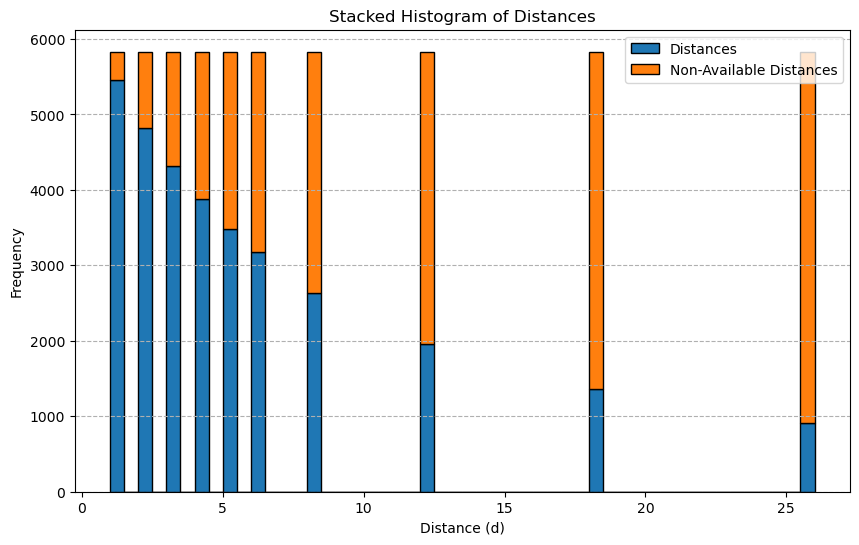

In [4]:
import matplotlib.pyplot as plt

# Combine distances and na_distances into a list of datasets
data = [distances, na_distances]

# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, edgecolor='black', stacked=True, label=['Distances', 'Non-Available Distances'])

# Add labels and title
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Distances')

# Add grid and legend
plt.grid(axis='y', linestyle='--')
plt.legend()

# Show the plot
plt.show()


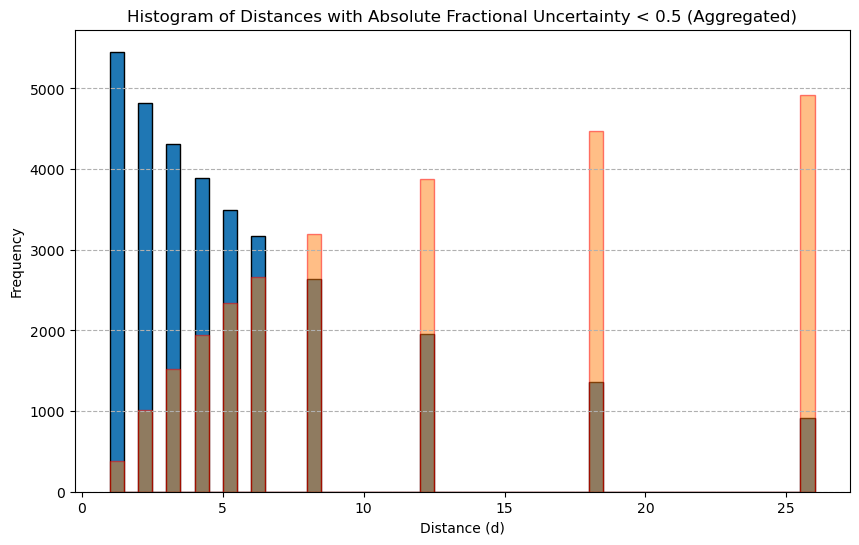

In [ ]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, edgecolor='black')
plt.hist(na_distances, bins=50, edgecolor='red', alpha=0.5, label='Non-Available Distances')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.yscale('log')
plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# Plot the histogram of the aggregated distances
plt.figure(figsize=(10, 6))
plt.hist(na_distances, bins=50, edgecolor='black')
plt.xlabel('Distance (d)')
plt.ylabel('Frequency')
# plt.title('Histogram of Distances with Absolute Fractional Uncertainty < 0.5 (Aggregated)')
plt.grid(axis='y', linestyle='--')
plt.show()

/tmp/ipykernel_1072591/338910748.py:5: FutureWarning: The provided callable <function median at 0x7f0df81f3b00> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values='d_fit', aggfunc=np.median)


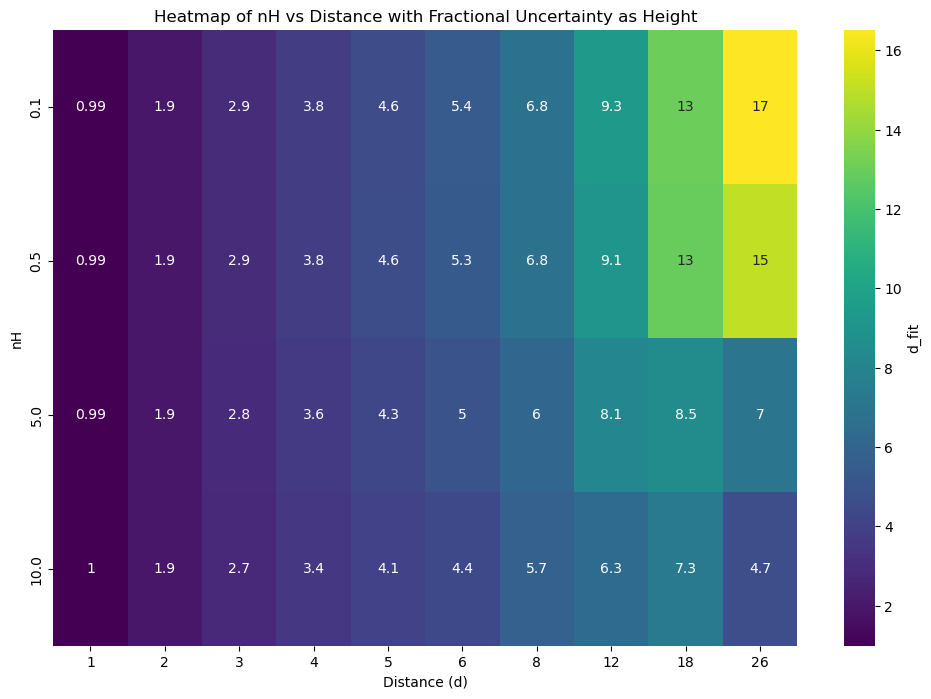

In [2]:
# Concatenate all the data into a single DataFrame
aggregated_data = pd.concat(all_data, ignore_index=True)

# Create a pivot table for the heatmap
heatmap_data = aggregated_data.pivot_table(index='nH', columns='d', values='d_fit', aggfunc=np.median)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, cbar_kws={'label': 'd_fit'})
plt.xlabel('Distance (d)') 
plt.ylabel('nH')
plt.title('Heatmap of nH vs Distance with Fractional Uncertainty as Height')
plt.show()


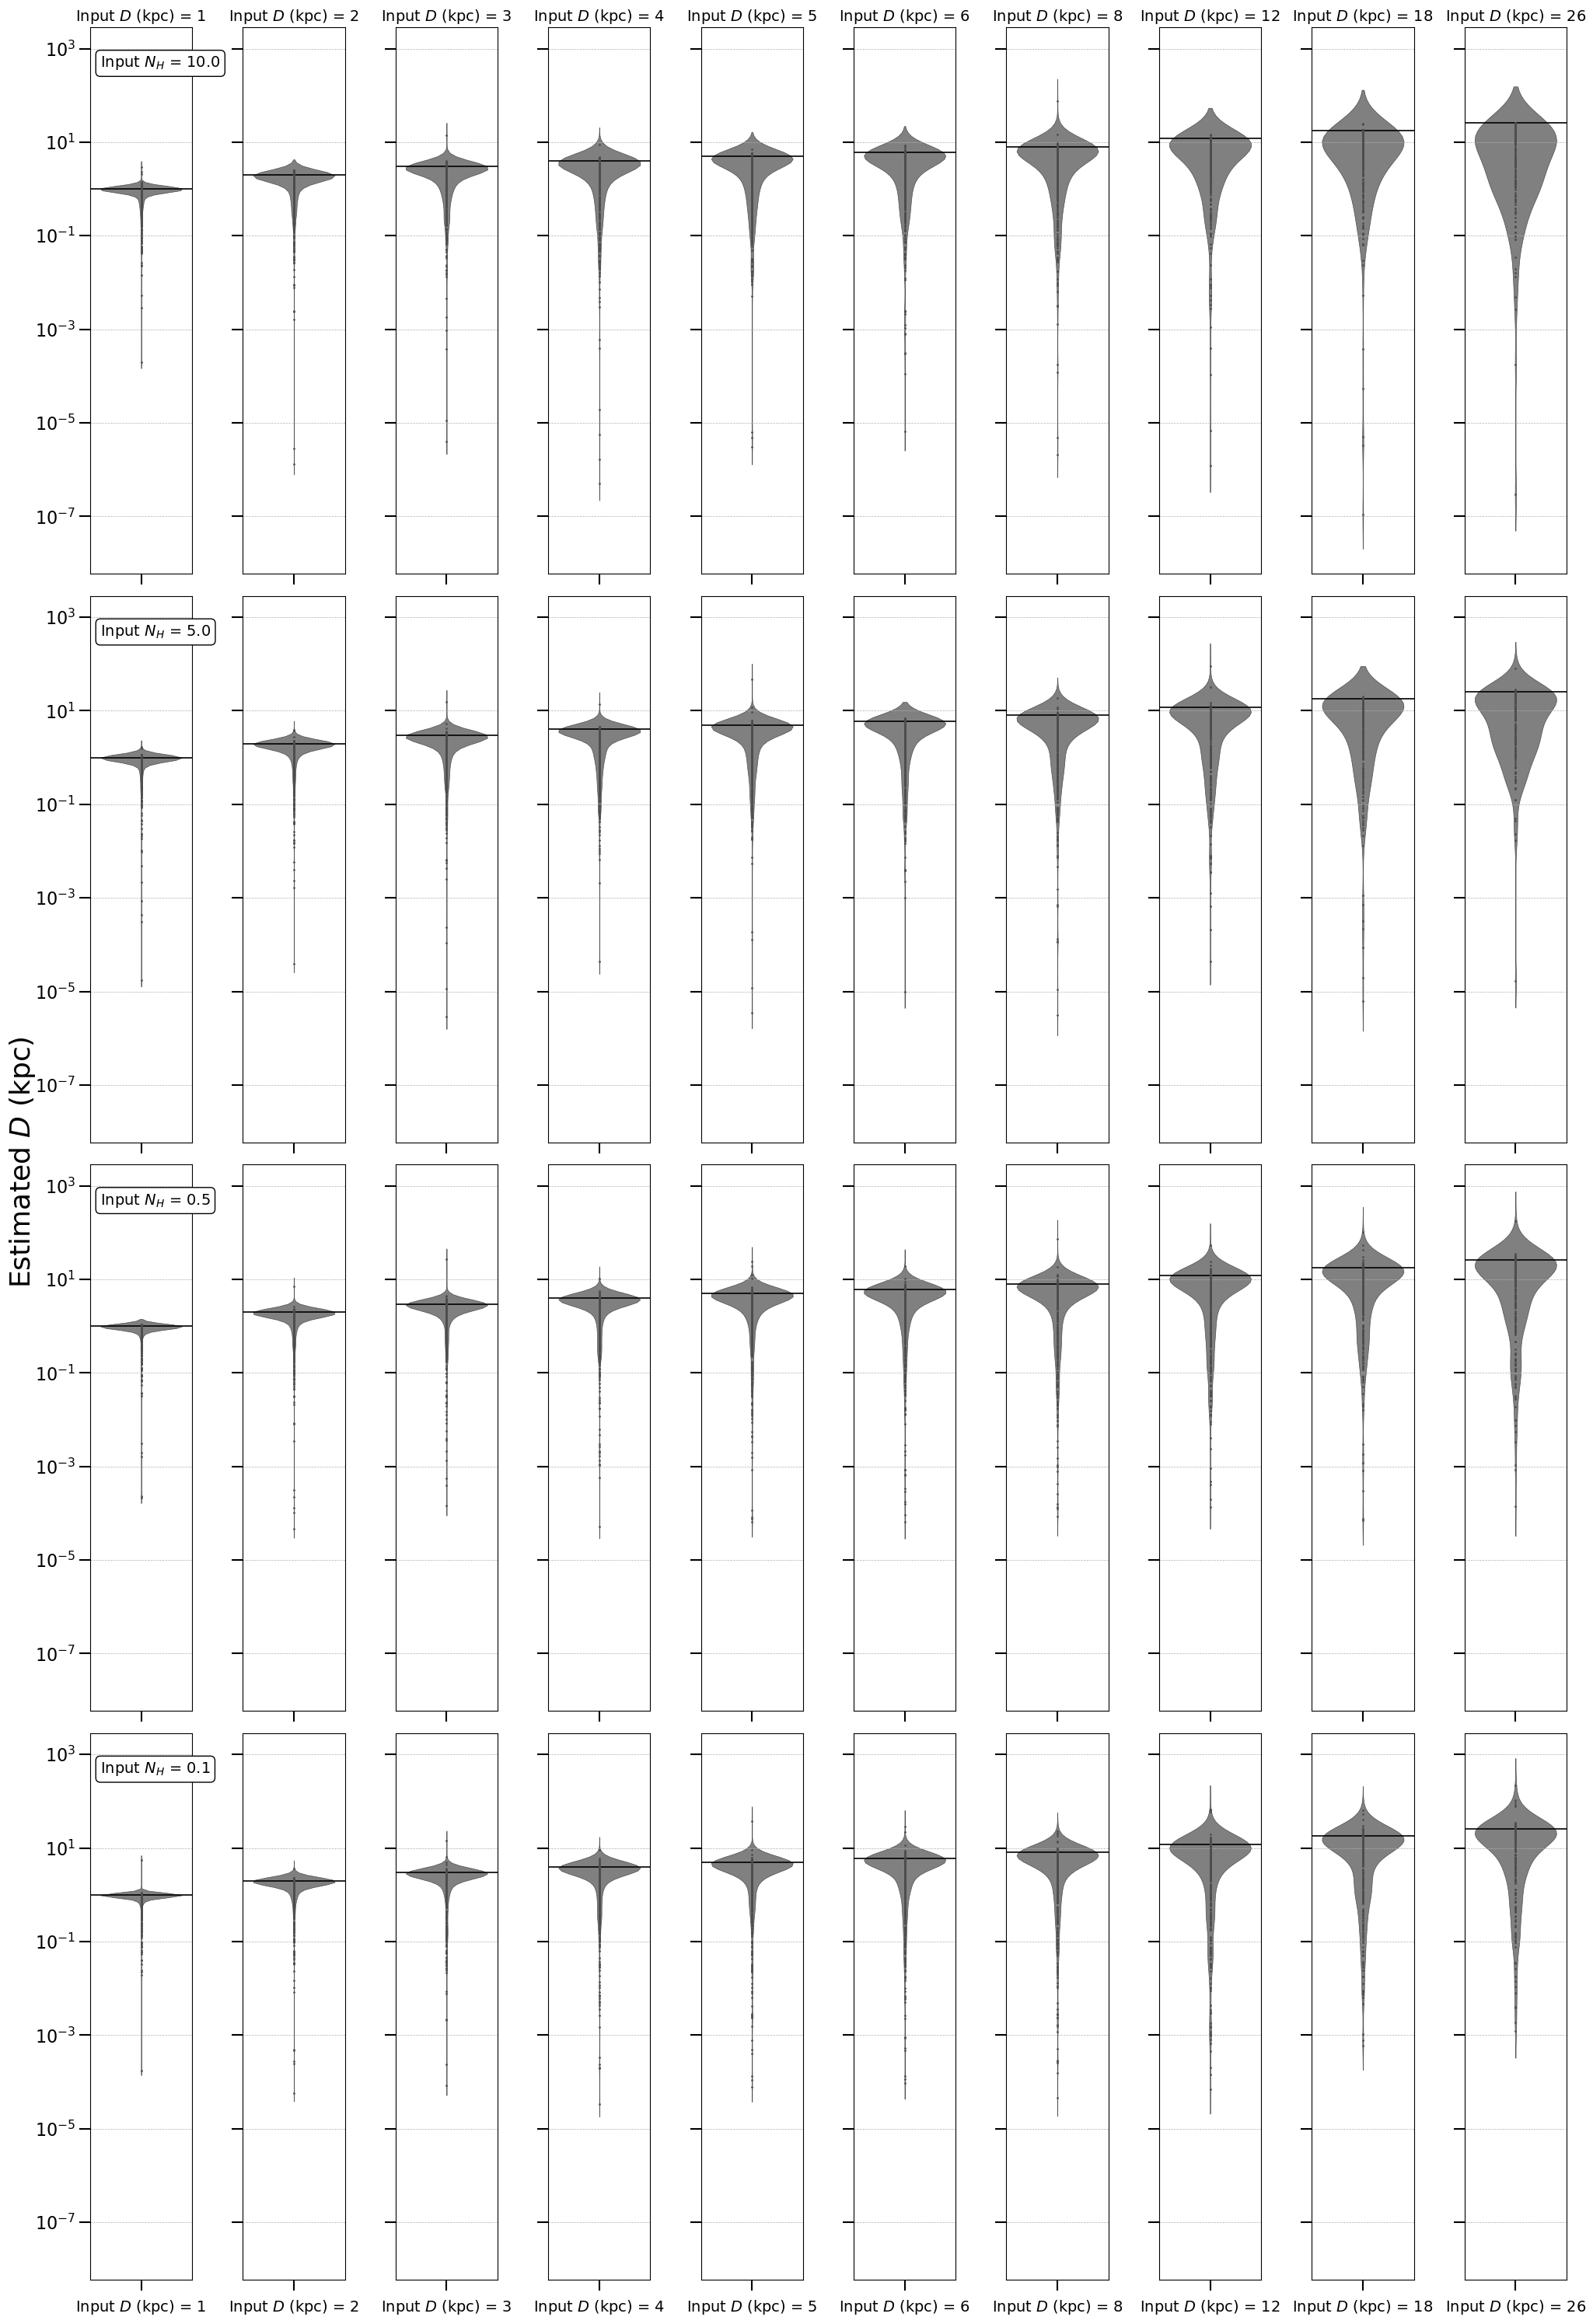

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group the data by 'nH' and 'd'
grouped_data = aggregated_data.groupby(['nH', 'd'])

# Define unique values of nH and d for the grid layout
nH_values = sorted(aggregated_data['nH'].unique(), reverse=True)
d_values = sorted(aggregated_data['d'].unique())

# Adjust figure size to a 16:9 aspect ratio for presentation slides
fig, axes = plt.subplots(len(nH_values), len(d_values), figsize=(20,30), sharex=True, sharey=True)
# fig.suptitle("Distribution of d_fit for each nH and d", fontsize=26)

# Iterate through each nH and d to plot the distribution at each grid cell
for i, nH in enumerate(nH_values):
    for j, d in enumerate(d_values):
        ax = axes[i, j]
        
        # Get the distribution of d_fit for each combination of nH and d
        subset = grouped_data.get_group((nH, d))['d_fit'] if (nH, d) in grouped_data.groups else []
        
        ax.set_yscale('log')
        # Plot the distribution as a violin plot or box plot
        if len(subset) > 0:
            sns.violinplot(y=subset, ax=ax, inner="point", color="grey", linewidth=0.5)
        
        # Add grid to each subplot on y-axis only
        ax.grid(True, axis='y',which='both', linestyle='--', linewidth=0.5)
        
        # Remove the default y-label
        ax.set_ylabel("")

        ax.axhline(y=d_values[j], color="black", linestyle='-', linewidth=1.2)  # Updated line style and width

        # Set titles and labels for the first row and column
        if i == 0:
            ax.set_title(f"Input $D$ (kpc) = {d}", fontsize=14)
        # if j == 0:
        #     ax.set_ylabel(f"Input $N_H$ = {nH}", fontsize=14)
                # Add N_H label inside the panel (top-left corner)
        if j == 0:  # Only add label once per row
            ax.text(0.1, 0.95, f"Input $N_H$ = {nH}", transform=ax.transAxes,
                    fontsize=14, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        if i == len(nH_values) - 1:
            ax.set_xlabel(f"Input $D$ (kpc) = {d}", fontsize=14)

        # Increase font size for axes ticks
        ax.tick_params(axis='both', which='major', labelsize=16, length=10, width=1.5)
        ax.tick_params(axis='both', which='minor', labelsize=16, length=5, width=1)

# Adjust spacing between subplots to remove gaps between rows and columns
fig.text(-0.01, 0.5, 'Estimated $D$ (kpc)', va='center', rotation='vertical', fontsize=26)
plt.tight_layout()
plt.savefig(f"plots/{instr}/2d_violin_plot_{instr}.pdf")
plt.show()


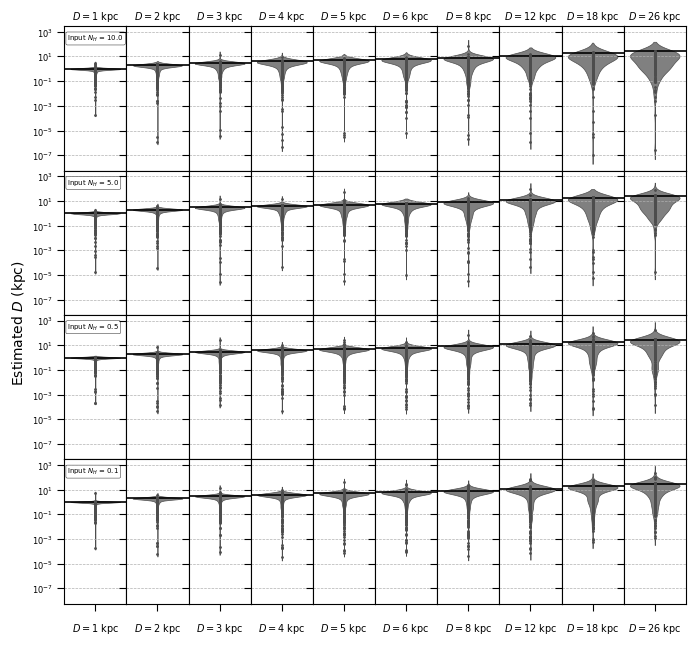

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'nH' and 'd'
grouped_data = aggregated_data.groupby(['nH', 'd'])

# Define unique values of nH and d for the grid layout
nH_values = sorted(aggregated_data['nH'].unique(), reverse=True)
d_values = sorted(aggregated_data['d'].unique())

# Adjust figure size to fit MNRAS page dimensions
fig_width = 6.974  # MNRAS page width in inches
fig_height_per_row = 1.8  # Adjusted height per row
fig_height = fig_height_per_row * len(nH_values)

fig, axes = plt.subplots(
    len(nH_values), len(d_values),
    figsize=(fig_width, fig_height),
    sharex=True, sharey=True,  # Share x and y axes
    gridspec_kw={'wspace': 0, 'hspace': 0}  # Overlap axes
)

# Get global y-axis limits
all_d_fit_values = aggregated_data['d_fit']
# ymin, ymax = all_d_fit_values.min(), all_d_fit_values.max()

# Iterate through each nH and d to plot the distribution at each grid cell
for i, nH in enumerate(nH_values):
    for j, d in enumerate(d_values):
        ax = axes[i, j]

        # Get the distribution of d_fit for each combination of nH and d
        subset = grouped_data.get_group((nH, d))['d_fit'] if (nH, d) in grouped_data.groups else []
        
        ax.set_yscale('log')
        
        if len(subset) > 0:
            sns.violinplot(y=subset, ax=ax, inner="point", color="grey", linewidth=0.5)
        
        # Reduce grid lines to only major ticks on the y-axis
        ax.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)

        # Set consistent y-axis limits
        # ax.set_ylim(ymin, ymax)

        # Remove the default y-label
        ax.set_ylabel("")

        # Horizontal line for reference
        ax.axhline(y=d_values[j], color="black", linestyle='-', linewidth=1.2)

        # Set titles and labels
        if i == 0:
            ax.set_title(f"$D = {d}$ kpc", fontsize=7, pad=5)  # Font size adjusted
        # if j == 0:
        #     ax.set_ylabel(f"$N_H = {nH}$", fontsize=7, labelpad=2)  # Reduced padding

        if j == 0:  # Only add label once per row
            ax.text(0.05, 0.95, f"Input $N_H$ = {nH}", transform=ax.transAxes,
                    fontsize=5, verticalalignment='top', horizontalalignment='left',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2',linewidth=0.3))

        # Add x-axis labels for the bottom row
        if i == len(nH_values) - 1:
            ax.set_xlabel(f"$D = {d}$ kpc", fontsize=7)
            ax.tick_params(axis='x', rotation=45)  # Rotate x-labels

        # Customize ticks
        ax.tick_params(axis='both', which='major', labelsize=6, length=5, width=0.8)
        ax.tick_params(axis='both', which='minor', labelsize=6, length=3, width=0.5)

# Shared ylabel positioned closer to the subplots
fig.text(0.015, 0.5, 'Estimated $D$ (kpc)', va='center', rotation='vertical', fontsize=10)

# Adjust layout to ensure no text overlap
plt.tight_layout(pad=0.8, rect=[0.03, 0.05, 1, 0.95])

# Save the figure as a high-resolution PDF
plt.savefig(f"plots/{instr}/2d_violin_plot_{instr}.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define unique values of nH and d for the grid layout
nH_values = sorted(aggregated_data['nH'].unique())
d_values = sorted(aggregated_data['d'].unique())

# Create a subplot grid with shared x and y axes
fig = make_subplots(
    rows=len(nH_values),
    cols=len(d_values),
    shared_xaxes=True,
    shared_yaxes=True,
    horizontal_spacing=0.01,
    vertical_spacing=0.01,
    subplot_titles=[f"d = {d}" for d in d_values] * len(nH_values),
)

# Iterate through each nH and d to plot the distribution at each grid cell
for i, nH in enumerate(nH_values):
    for j, d in enumerate(d_values):
        # Get the distribution of d_fit for each combination of nH and d
        subset = aggregated_data[(aggregated_data['nH'] == nH) & (aggregated_data['d'] == d)]['d_fit']
        
        if len(subset) > 0:
            # Add a violin plot to the respective grid cell
            fig.add_trace(
                go.Violin(y=subset, box_visible=True, meanline_visible=True, name=f"nH: {nH}, d: {d}"),
                row=i + 1,
                col=j + 1
            )

# Update layout for interactivity and adjust y-axis labels for each row
fig.update_layout(
    title_text="Interactive Distribution of d_fit for each nH and d",
    showlegend=False,
    height=1200,
    width=1000,
)

# Set nH values as y-axis labels for each row individually
for i, nH in enumerate(nH_values):
    fig.update_yaxes(title_text=f"nH = {nH}", row=i + 1, col=1)

# Set d_fit as the x-axis label for the bottom row
fig.update_xaxes(title_text="d_fit", row=len(nH_values), col=1)

# Show the interactive plot
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Use all_data_params here
    # Ensure each dictionary of parameters matches the length of each data_df
    params_df = pd.DataFrame([params] * len(data_df))  # Repeat the parameter dictionary for each row
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Define the parameters to aggregate by
parameters = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Step 3: Loop through each parameter and create a violin plot based on that parameter
for param in parameters:
    # Define unique values for the current parameter and for distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())

    # Create a subplot grid with each row corresponding to a unique parameter value
    fig = make_subplots(
        rows=len(param_values), cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        subplot_titles=[f"{param} = {val}" for val in param_values],
    )

    # Step 4: Iterate through each value of the current parameter to create violin plots by distance
    for i, val in enumerate(param_values):
        # Filter the data for the current parameter value
        subset = all_data_flat[all_data_flat[param] == val]

        # Prepare hover text and KDE for each distance grouping
        for d in d_values:
            d_subset = subset[subset['d'] == d]
            if len(d_subset) > 1:  # KDE requires more than one data point
                d_fit_values = d_subset['d_fit']

                # Prepare hover text for the KDE
                hovertext = f"{param}: {val}<br>d: {d}<br>KDE-estimated y-values (d_fit)"

                # Add a violin plot for the current distance
                fig.add_trace(
                    go.Violin(
                        x=[d] * len(d_fit_values),  # Set x to the current distance value
                        y=d_fit_values,             # Set y to d_fit values
                        box_visible=True,
                        meanline_visible=True,
                        name=f"d = {d}",
                        hoveron='kde',  # Use KDE y-values for hover
                        hovertext=hovertext,
                        showlegend=False,
                        points=False  # Do not show individual points
                    ),
                    row=i + 1,
                    col=1
                )

    # Update layout for the current parameter's plot
    fig.update_layout(
        title_text=f"Distribution of KDE-estimated d_fit for each Distance (d) by {param}",
        showlegend=False,
        height=400 * len(param_values),  # Adjust height based on the number of parameter values
        width=1000,
        xaxis_title="Distance (d)",
        yaxis_title="KDE-estimated d_fit",
    )

    # Show the plot for the current parameter
    fig.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Use all_data_params here
    # Ensure each dictionary of parameters matches the length of each data_df
    params_df = pd.DataFrame([params] * len(data_df))  # Repeat the parameter dictionary for each row
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Define the parameters to aggregate by
parameters = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Create directory if it doesn't exist
os.makedirs('plots/"+instr+"', exist_ok=True)

# Step 3: Loop through each parameter and create a violin plot based on that parameter
for param in parameters:
    # Define unique values for the current parameter and for distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())

    # Create subplots with each row corresponding to a unique parameter value
    fig, axes = plt.subplots(len(param_values), 1, figsize=(10, 5 * len(param_values)), sharex=True)
    # fig.suptitle(f"Distribution of d_fit for each Distance (d) by {param}", fontsize=16)

    # Step 4: Iterate through each value of the current parameter to create violin plots by distance
    for i, (ax, val) in enumerate(zip(axes, param_values)):
        # Filter the data for the current parameter value
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()

        # Prepare data for plotting
        if not subset.empty:
            subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for discrete categories
            ax.set_yscale('log')  # Set y-axis to log scale before plotting
            palette = sns.color_palette('colorblind', len(d_values))  # Use a new distinctive color palette
            sns.violinplot(
                data=subset,
                x='d', 
                y='d_fit',
                ax=ax,
                density_norm='width',  # Updated to use the new parameter name
                inner=None,  # Remove quantiles from the plot
                hue='d',  # Assign the x variable to hue
                palette=palette,  # Use the palette for colors
                legend=False  # Disable legend for clarity
            )

            # Add horizontal lines at d values on d_fit axis with matching colors
            for d_idx, d_value in enumerate(d_values):
                ax.axhline(y=d_value, color=palette[d_idx], linestyle='--', linewidth=1.2)  # Updated line style and width

        ax.set_title(f"{param} = {val}", fontsize=14)
        ax.set_ylabel("d_fit (log scale)", fontsize=12)
        ax.grid(True, which='both', linestyle=':', linewidth=0.5)

    # Set x-axis labels for the last subplot
    axes[-1].set_xlabel("Distance (d)", fontsize=12)

    # Adjust layout for clarity and save the figure
    plt.tight_layout()
    plt.savefig(f"plots/{instr}/{param}_violin_plot_{instur}.png")
    plt.close(fig)


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as ticker

# Define the parameter labels with proper LaTeX formatting and units
parameter_labels = {
    'g': r"$\Gamma$",                        # Gamma (no unit label)
    'T': r"$T$ (keV)",                       # Temperature in keV
    'a': r"$a$",                              # Spin parameter (no unit label)
    'm': r"$M_{\odot}$",                     # Mass in solar masses
    'i': r"$i$ (degrees)",                   # Inclination in degrees
    'r': r"Disk-to-total ratio",             # Disk to total ratio (no unit label)
    'e': r"Exposure (sec)"                   # Exposure in seconds
}

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Match each dataset with its parameters
    # Repeat the parameter dictionary for each row in the corresponding data_df
    params_df = pd.DataFrame([params] * len(data_df))
    # Concatenate data and parameters
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Define the parameters to aggregate by
parameters = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Create directory if it doesn't exist
os.makedirs('plots/maxi', exist_ok=True)

# Step 3: Loop through each parameter and create violin plots
for param in parameters:
    # Get unique values for the current parameter and distance
    param_values = sorted(all_data_flat[param].unique())
    d_values = sorted(all_data_flat['d'].unique())

    # Create subplots for the current parameter
    fig, axes = plt.subplots(
        len(param_values), 1,
        figsize=(3.3, len(param_values) * 1.5),  # Single-column layout
        sharex=True
    )

    # Iterate through each parameter value and plot distributions
    for i, (ax, val) in enumerate(zip(axes, param_values)):
        # Filter the data for the current parameter value
        subset = all_data_flat.loc[all_data_flat[param] == val].copy()

        if not subset.empty:
            subset['d'] = subset['d'].astype(str)  # Convert 'd' to string for categorical x-axis
            ax.set_yscale('log')  # Use log scale for y-axis
            palette = sns.color_palette('colorblind', len(d_values))  # Colorblind-friendly palette
            sns.violinplot(
                data=subset,
                x='d',
                y='d_fit',
                ax=ax,
                hue='d',  # Assign hue to the same as x-axis
                inner=None,  # No internal marks
                palette=palette,
                linewidth=0.3,  # Reduced line width for clarity
                legend=False  # Suppress legend
            )

            # Dynamically calculate the true x-axis limits after padding
            x_limits = ax.get_xlim()
            x_left = x_limits[0]  # True left edge of the axis
            for d_idx, d_value in enumerate(d_values):
                # Get subset of data for the current `d_value`
                data_d_value = subset.loc[subset['d'] == str(d_value), 'd_fit']
                if not data_d_value.empty:
                    x_max = d_idx + 0.3  # Slightly after the violin's center
                    ax.plot([x_left, x_max], [d_value, d_value], color=palette[d_idx], linestyle='-', linewidth=0.5)

        # Add titles using parameter_labels
        ax.set_title(f"{parameter_labels[param]} = {val}", fontsize=7, pad=2)
        ax.set_ylabel("Estimated $D$ (log)", fontsize=7, labelpad=2)
        ax.grid(True, which='major', linestyle=':', linewidth=0.3)

        # Adjust tick size to match label font size
        ax.tick_params(axis='both', which='major', labelsize=7, length=3, width=0.3)
        ax.tick_params(axis='both', which='minor', labelsize=7, length=2, width=0.3)

        # Adjust the y-axis ticks explicitly for log scaling
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))  # Max 5 major ticks
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs="auto", numticks=10))  # Minor ticks
        ax.set_xlim(x_limits)

    # Add x-axis label for the bottom plot
    axes[-1].set_xlabel("$D$ (kpc)", fontsize=7)

    # Adjust layout to ensure no overlaps and save the figure
    plt.tight_layout(pad=0.8)
    plt.savefig(f"plots/"+instr+"/{param}_violin_plot.png", dpi=300, bbox_inches='tight')
    plt.close(fig)


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Use all_data_params here
    # Ensure each dictionary of parameters matches the length of each data_df
    params_df = pd.DataFrame([params] * len(data_df))  # Repeat the parameter dictionary for each row
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Step 3: Define unique values of a and T to set up interaction plots
a_values = sorted(all_data_flat['a'].unique())
T_values = sorted(all_data_flat['T'].unique())

# Create a subplot grid for each combination of a and T
fig = make_subplots(
    rows=len(a_values), cols=len(T_values),
    shared_yaxes=True,
    shared_xaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=[f"a = {a}, T = {T}" for a in a_values for T in T_values],
)

# Step 4: Iterate through each combination of a and T and plot distance distributions
for i, a_val in enumerate(a_values):
    for j, T_val in enumerate(T_values):
        # Filter the data for the current a and T combination
        subset = all_data_flat[(all_data_flat['a'] == a_val) & (all_data_flat['T'] == T_val)]
        
        # Prepare a violin plot for each distance value within this subset
        d_values = sorted(subset['d'].unique())
        
        for d in d_values:
            d_subset = subset[subset['d'] == d]
            if len(d_subset) > 0:
                d_fit_values = d_subset['d_fit']
                
                # Prepare hover text for the KDE
                hovertext = f"{param}: {val}<br>d: {d}<br>KDE-estimated y-values (d_fit)"

                # Add violin plot for current distance in the subplot
                fig.add_trace(
                    go.Violin(
                        x=[d] * len(d_fit_values),  # Set x to the current distance value
                        y=d_fit_values,             # Set y to d_fit values
                        box_visible=True,
                        meanline_visible=True,
                        name=f"d = {d}",
                        hoveron='kde',
                        hovertext=hovertext,
                        showlegend=False,
                        points=False,  # Do not show individual points,
                    ),
                    row=i + 1,
                    col=j + 1
                )

# Update layout for better readability
fig.update_layout(
    title_text="Interaction Plot of Distance Distribution for each (a, T) Combination",
    height=500 * len(a_values),  # Adjust height based on number of rows (a values)
    width=500 * len(T_values),   # Adjust width based on number of columns (T values)
    xaxis_title="Distance (d)",
    yaxis_title="d_fit",
    showlegend=False
)

# Show the interactive plot
fig.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde

# Step 1: Attach parameters to each entry in all_data using all_data_params
all_data_with_params = []
for data_df, params in zip(all_data, all_data_params):  # Use all_data_params here
    # Ensure each dictionary of parameters matches the length of each data_df
    params_df = pd.DataFrame([params] * len(data_df))  # Repeat the parameter dictionary for each row
    data_with_params = pd.concat([data_df.reset_index(drop=True), params_df.reset_index(drop=True)], axis=1)
    all_data_with_params.append(data_with_params)

# Step 2: Concatenate all entries into a single DataFrame
all_data_flat = pd.concat(all_data_with_params, ignore_index=True)

# Step 3: Define unique values of e, a, and T to set up multiple interaction plots
e_values = sorted(all_data_flat['e'].unique())[:3]  # Select only the first 3 unique values of e
a_values = sorted(all_data_flat['a'].unique())
T_values = sorted(all_data_flat['T'].unique())

# Step 4: Create a separate plot for each value of e
for e_val in e_values:
    # Filter data for the current value of e
    e_subset = all_data_flat[all_data_flat['e'] == e_val]

    # Create a subplot grid for each combination of a and T
    fig = make_subplots(
        rows=len(a_values), cols=len(T_values),
        shared_yaxes=True,
        shared_xaxes=True,
        vertical_spacing=0.05,
        horizontal_spacing=0.05,
        subplot_titles=[f"a = {a}, T = {T}" for a in a_values for T in T_values],
    )

    # Step 5: Iterate through each combination of a and T and plot distance distributions
    for i, a_val in enumerate(a_values):
        for j, T_val in enumerate(T_values):
            # Filter the data for the current a and T combination within this e subset
            subset = e_subset[(e_subset['a'] == a_val) & (e_subset['T'] == T_val)]
            
            # Prepare a violin plot for each distance value within this subset
            d_values = sorted(subset['d'].unique())
            
            for d in d_values:
                d_subset = subset[subset['d'] == d]
                if len(d_subset) > 1:  # KDE requires more than one data point
                    d_fit_values = d_subset['d_fit']
                    
                    # Calculate KDE for d_fit values
                    kde = gaussian_kde(d_fit_values)
                    y_kde = np.linspace(d_fit_values.min(), d_fit_values.max(), 100)  # y-values for KDE
                    kde_values = kde(y_kde)  # KDE density values

                    # Prepare hover text for KDE values
                    hovertext_kde = [f"a: {a_val}<br>T: {T_val}<br>d: {d}<br>KDE d_fit: {y:.2f}" for y in y_kde]

                    # Add violin plot for current distance in the subplot
                    fig.add_trace(
                        go.Violin(
                            x=[d] * len(d_fit_values),  # Set x to the current distance value
                            y=d_fit_values,             # Set y to d_fit values
                            box_visible=True,
                            meanline_visible=True,
                            name=f"d = {d}",
                            showlegend=False,
                            points=False  # Do not show individual points
                        ),
                        row=i + 1,
                        col=j + 1
                    )

                    # Overlay KDE points with hover text showing KDE-estimated y-values
                    fig.add_trace(
                        go.Scatter(
                            x=[d] * len(y_kde),  # Repeat distance for KDE samples
                            y=y_kde,             # KDE y-values
                            mode="markers",
                            marker=dict(size=1, opacity=0),  # Invisible markers to enable hover text
                            hovertext=hovertext_kde,
                            hoverinfo="text",
                            showlegend=False
                        ),
                        row=i + 1,
                        col=j + 1
                    )

    # Update layout for better readability
    fig.update_layout(
        title_text=f"Interaction Plot of Distance Distribution for each (a, T) Combination (e = {e_val})",
        height=500 * len(a_values),  # Adjust height based on number of rows (a values)
        width=500 * len(T_values),   # Adjust width based on number of columns (T values)
        xaxis_title="Distance (d)",
        yaxis_title="d_fit",
        showlegend=False
    )

    # Show the interactive plot for the current value of e
    fig.show()


In [ ]:
# Plot histograms for each parameter in files that have 'd_fit' = NaN
plt.figure(figsize=(15, 10))
parameter_names = ['g', 'T', 'a', 'm', 'i', 'r', 'e']

# Iterate over parameters and plot histograms in a 2x3 layout
for idx, param_name in enumerate(parameter_names[:7]):  # Only using the first 6 parameters for the 2x3 layout
    values = [params[param_name] for params in na_d_fit_params if param_name in params]
    plt.subplot(3, 3, idx + 1)
    plt.hist(values, bins=15, edgecolor='black', alpha=0.7)
    plt.xlabel(param_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Parameter: {param_name} (Files with d_fit = NaN)')

plt.tight_layout()
plt.show()

In [ ]:
# Plot a 2D histogram for 'nH' and 'd' of non-available distances
plt.figure(figsize=(10, 6))
plt.hist2d(na_distances,na_nH, bins=([1,2,3,4,5,6,8,12,18,27], [0,3.3,6.7,10]), cmap='viridis')
plt.ylabel('nH')
plt.xlabel('Distance (d)')
plt.colorbar(label='Count')
plt.title('2D Histogram of nH and Distance for Non-Available Distances')
plt.show()

In [ ]:
# Define bin edges
x_bins = [1, 2, 3, 4, 5, 6, 8, 12, 18, 27]
y_bins = [0, 3.3, 6.7, 10]

# Plot a 2D histogram for 'nH' and 'd' of non-available distances
plt.figure(figsize=(10, 6))
hist, x_edges, y_edges, im = plt.hist2d(na_distances, na_nH, bins=(x_bins, y_bins), cmap='viridis')
plt.ylabel('nH')
plt.xlabel('Distance (d)')
plt.colorbar(label='Count')
plt.title('2D Histogram of nH and Distance for Non-Available Distances')

# Annotate counts on the cells
for i in range(len(x_edges) - 1):
    for j in range(len(y_edges) - 1):
        count = hist[i, j]
        if count > 0:  # Only annotate non-empty bins
            plt.text((x_edges[i] + x_edges[i + 1]) / 2,
                     (y_edges[j] + y_edges[j + 1]) / 2,
                     int(count),
                     ha='center', va='center', color='white')
                     
plt.show()